### Packages

In [2]:
!pip install keras-metrics

In [3]:
import zipfile
from google.colab import drive
from PIL import Image

import re
import glob
import os
import imageio
import random
import math
import tempfile
import logging
import shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
import keras_metrics as km

# Tensorflow
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

# Torch, scipy, medpy, skimage
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from scipy import ndimage
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.interpolation import map_coordinates
from skimage.transform import resize, rescale
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix

In [4]:
# Check GPU avalibility
import torch
torch.cuda.is_available()

True

### Mount Google drive

In [5]:
# Mount google drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### rnn test


In [6]:
%cd '/content/drive/My Drive/CV_Dataset/'
%ls

/content/drive/My Drive/CV_Dataset
kinetic_leap_dataset/  model.png  senz3d_dataset/  UCF50/


In [7]:
# Variables (adjustable)
val_split = 0.1  # NOT USED DUE TO LIMITED DATA
test_split = 0.1 # NOT USED DUE TO LIMITED DATA
downsample = 0.25
crop_rate = 1

n_epochs = 100
batch_size = 2
isReadimg = False

method = 'depth_img'
train_method = 'diff_map'
max_seq_len = 5

dataset = 'senz3d'


if dataset == 'senz3d':

  # People folders to use
  people_list = ['S1', 'S2', 'S3', 'S4']   
  #people_list = ['S1']  

  # Gesture folders to use
  gestures_list = ['G1', 'G2', 'G3', 'G4', 'G5', 'G6','G7','G8', 'G9', 'G10', 'G11'] 
  #gestures_list = ['G1']

  %cd '/content/drive/My Drive/CV_Dataset/senz3d_dataset/'


n_gestures = len(gestures_list)
n_people = len(people_list)
classes = ["Five", "Two", "Eight", "Oath", "Fist", "Horn", "One", "Four", "Three", "Horizontal thumb", "Little Finger"]

/content/drive/My Drive/CV_Dataset/senz3d_dataset


### Functions to create data (video frames)

In [8]:
def center_crop(img, dim):
    """
    Perform center cropping of an given image

    Args:
    img: input image to be cropped
    dim: 2-tuple that specifies the crop dimension
    """
    width, height = img.shape[1], img.shape[0]
    mid_x, mid_y = int(width/2), int(height/2)

    crop_width = dim[0] if dim[0]<img.shape[1] else img.shape[1]
    crop_height = dim[1] if dim[1]<img.shape[0] else img.shape[0] 

    cw2,ch2 = int(crop_width/2), int(crop_height/2)
    crop_img = img[mid_x-cw2:mid_x+cw2, mid_y-ch2:mid_y+ch2]
    return crop_img

def create_data(input_dir, data_save_path, downsample, crop_rate, train_method, max_seq_len):
    """
    Create training data and labels for Senz3D dataset

    Args:
    input_dir: path to Senz3D dataset
    data_save_path: path to save the training data and labels
    downsample: a float that specifies the downsample ratio (0.0-1.0)
    crop_rate: a float that specifies the cropping ratio (0.0-1.0)
    """
    
    people_dir = os.listdir(input_dir)
    print(people_dir)

    X_img = []
    X_dimg = []
    X_conf = []
    Y = []

    label = 0
    for gest in gestures_list:
      for people in people_list:

        base_path = os.path.join(os.path.join(input_dir, people), gest)
        print('Reading images from: {} | Gesture: {}'.format(os.path.join(people, gest), classes[label]))

        if os.path.exists(base_path):

          #　Image path
          img_paths = glob.glob(base_path + '/*-color.png')
          dimg_paths = glob.glob(base_path + '/*-depth.bin')
          conf_paths = glob.glob(base_path + '/*-conf.bin')
          assert len(img_paths) == len(dimg_paths)

          img_arr = []
          dimg_arr = []
          conf_arr = []
          prev_img_cc = np.array([])
          prev_dimg_cc = np.array([])
          prev_conf_cc =  np.array([])

          if max_seq_len > len(img_paths):
            max_seq_len = len(img_paths)

          for i in range(len(img_paths)):

            # Load all images (rgb, depth, confidence map)
            img = imageio.imread(img_paths[i])
            h = 240
            w = 320
            with open(dimg_paths[i], mode='rb') as f:
                dimg = np.fromfile(f,dtype=np.uint16,count=w*h).reshape(h,w)
                f.close()
            with open(dimg_paths[i], mode='rb') as f:
                conf = np.fromfile(f,dtype=np.uint16,count=w*h).reshape(h,w)
                f.close()

            # Downsampling
            img_rs = rescale(img, downsample, anti_aliasing=True, multichannel= True)
            dimg_rs = rescale(dimg, downsample*2, anti_aliasing=True)
            conf_rs = rescale(conf, downsample*2, anti_aliasing=True)   

            # plt.imshow(img_rs)
            # plt.show()
            # img_rs_shape = img_rs.shape
            #print(img_rs.shape)

            # Center crop
            img_cc = center_crop(img_rs, (math.floor(img_rs.shape[0]*crop_rate), math.floor(img_rs.shape[1]*crop_rate)))
            dimg_cc = center_crop(dimg_rs, (math.floor(dimg_rs.shape[0]*crop_rate), math.floor(dimg_rs.shape[1]*crop_rate)))
            conf_cc = center_crop(conf_rs, (math.floor(conf_rs.shape[0]*crop_rate), math.floor(conf_rs.shape[1]*crop_rate)))

            # print(img_cc.shape)
            # plt.imshow(img_cc)
            # plt.show()
            # print(dasdas)

            # No methods implemented
            if train_method == 'none':
              img_arr.append(img_cc)
              dimg_arr.append(dimg_cc)
              conf_arr.append(conf_cc)

            # Difference map method (to remove background)
            elif train_method == 'diff_map':

              if prev_img_cc.shape == (0,):
                prev_img_cc = img_cc
                prev_dimg_cc = dimg_cc
                prev_conf_cc = conf_cc
              else: 
                img_arr.append(np.abs(img_cc-prev_img_cc))
                dimg_arr.append(np.abs(dimg_cc-prev_dimg_cc))
                conf_arr.append(np.abs(conf_cc-prev_conf_cc))                 
                prev_img_cc = img_cc
                prev_dimg_cc = dimg_cc
                prev_conf_cc = conf_cc

            # Save image if maximum frame in each video (max_seq_len) is specified
            if len(img_arr) == max_seq_len:

              X_img.append(np.asarray(img_arr))
              X_dimg.append(np.asarray(dimg_arr))
              X_conf.append(np.asarray(conf_arr))
              y = [0]*len(gestures_list)
              y[label] = 1
              Y.append(y)

              img_arr = []
              dimg_arr = []
              conf_arr = []
              prev_img_cc = np.array([])
              prev_dimg_cc = np.array([])
              prev_conf_cc = np.array([])

      label += 1

    X_img = np.asarray(X_img)
    X_dimg = np.asarray(X_dimg)
    X_conf = np.asarray(X_conf)
    Y = np.asarray(Y)

    data_dict = {
        'imgs':X_img,
        'dimgs':X_dimg,
        'labels':Y,
        'confs':X_conf
    }

    torch.save(data_dict, data_save_path)
    print('data saved to: {}'.format(data_save_path))

    return data_dict

In [9]:
data_name = 'p{}_g{}_ds{}_cr{}_{}_ml{}_RNN_data.pt'.format(n_gestures, n_people, downsample, crop_rate, train_method, max_seq_len)
data_dir = '/content/drive/My Drive/CV_Dataset/senz3d_dataset/acquisitions'
data_save_path =  os.getcwd() + '/save/data/' + data_name

# Load from saved file
if isReadimg or not os.path.exists(data_save_path):
  data_dict = create_data(data_dir, data_save_path, downsample, crop_rate, train_method, max_seq_len)
else:
  print('Loading data from {}'.format(data_save_path))
  data_dict = torch.load(data_save_path)

Loading data from /content/drive/My Drive/CV_Dataset/senz3d_dataset/save/data/p11_g4_ds0.25_cr1_diff_map_ml5_RNN_data.pt


### Get the train and test set

In [10]:
X = data_dict['imgs']    # Train with RGB images
#X = data_dict['dimgs']   # Train with depth images
#X = data_dict['confs']   # Train with confidence map
Y = data_dict['labels']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, shuffle=True, random_state=0)
print('X_train shape', X_train.shape)
print('X_test shape', X_test.shape)
print('y_train shape', y_train.shape)
print('y_test shape', y_test.shape)

X_train shape (165, 5, 100, 120, 3)
X_test shape (55, 5, 100, 120, 3)
y_train shape (165, 11)
y_test shape (55, 11)


### Preview images (frames in video)

Label: [0 0 0 0 0 0 0 0 0 0 1]


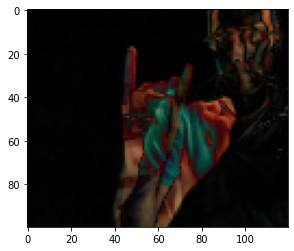

In [11]:
rand_id = np.random.randint(0, X_train.shape[0])
rand_frame = np.random.randint(0, X_train.shape[1]-1)

frame0 = X_train[rand_id,rand_frame]
frame1 = X_train[rand_id,rand_frame+1]
print('Label:', y_train[rand_id])
plt.imshow(frame0, cmap = 'gray')
plt.show()
# plt.imshow(np.abs(frame0-frame1), cmap = 'gray')
# plt.show()

In [25]:
model = Sequential()
model.add(ConvLSTM2D(filters = 64, kernel_size = (3, 3), padding='same', return_sequences = False, data_format = "channels_last", input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3], X_train.shape[4])))
model.add(Dropout(0.7))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.7))
model.add(Dense(n_gestures, activation = "softmax"))
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_16 (ConvLSTM2D) (None, 100, 120, 64)      154624    
_________________________________________________________________
dropout_13 (Dropout)         (None, 100, 120, 64)      0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 768000)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               196608256 
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 11)                2827      
Total params: 196,765,707
Trainable params: 196,765,707
Non-trainable params: 0
_______________________________________

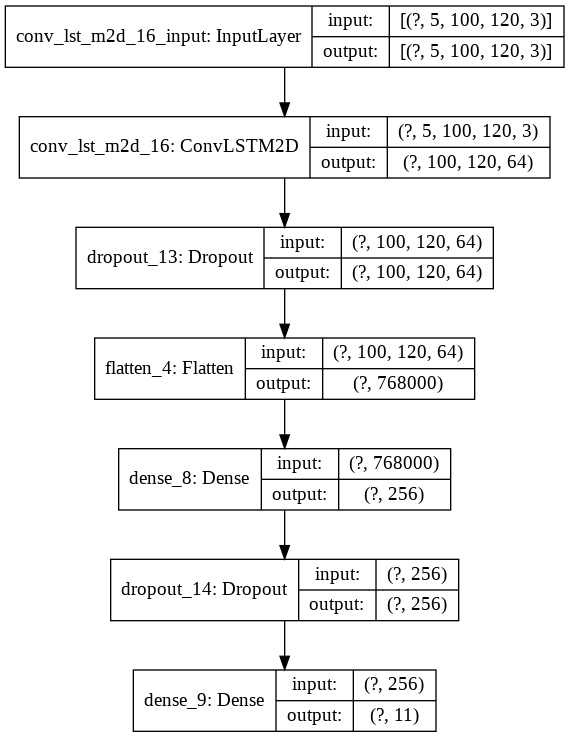

In [26]:
keras.utils.plot_model(model, show_shapes=True)

In [29]:
opt = keras.optimizers.SGD(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
 
earlystop = EarlyStopping(patience=100)
callbacks = [earlystop]

history = model.fit(x = X_train, y = y_train, epochs=1000, batch_size= 32, shuffle=True, validation_split=0.2, callbacks=callbacks)

Epoch 1/1000
5/5 [==============================] - 1s 249ms/step - loss: 0.1099 - accuracy: 0.9848 - val_loss: 1.4138 - val_accuracy: 0.5758
Epoch 2/1000
5/5 [==============================] - 1s 190ms/step - loss: 0.1603 - accuracy: 0.9773 - val_loss: 1.4280 - val_accuracy: 0.5758
Epoch 3/1000
5/5 [==============================] - 1s 190ms/step - loss: 0.1337 - accuracy: 0.9924 - val_loss: 1.4320 - val_accuracy: 0.5758
Epoch 4/1000
5/5 [==============================] - 1s 190ms/step - loss: 0.1268 - accuracy: 0.9924 - val_loss: 1.4307 - val_accuracy: 0.5758
Epoch 5/1000
5/5 [==============================] - 1s 190ms/step - loss: 0.1145 - accuracy: 0.9848 - val_loss: 1.4415 - val_accuracy: 0.6061
Epoch 6/1000
5/5 [==============================] - 1s 190ms/step - loss: 0.1616 - accuracy: 0.9697 - val_loss: 1.4312 - val_accuracy: 0.5758
Epoch 7/1000
5/5 [==============================] - 1s 190ms/step - loss: 0.1296 - accuracy: 0.9773 - val_loss: 1.4202 - val_accuracy: 0.6061
Epoch 

In [34]:
# test_generator = test_gen.flow(X_test, y_test, batch_size=batch_size)
[loss, acc] = model.evaluate(x=X_test, y=y_test,verbose=1)
print("Accuracy:" + str(acc))

2/2 [==============================] - 0s 51ms/step - loss: 1.6312 - accuracy: 0.6182
Accuracy:0.6181818246841431


/content/drive/My Drive/CV_Dataset/senz3d_dataset/save/result/depth_img_p11_g4_ds0.25_cr1_diff_map_ml5_e100_bs2_acc0.618182_RNN_result.png


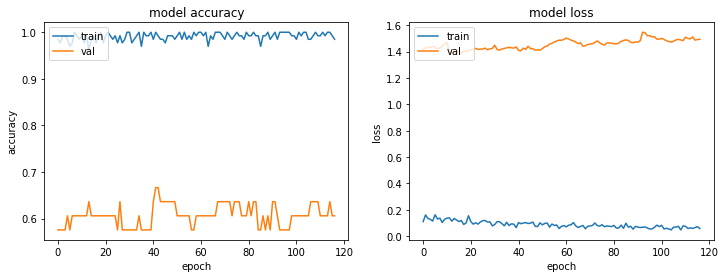

In [36]:
# summarize history for accuracy
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

ax2 = fig.add_subplot(1,2,2)
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')

result_name =  '{}_p{}_g{}_ds{}_cr{}_{}_ml{}_e{}_bs{}_acc{:2f}_RNN_result.png'.format(method, n_gestures, n_people, downsample, crop_rate, train_method, max_seq_len, n_epochs, batch_size, acc)
result_save_path = os.getcwd() + '/save/result/' + result_name
print(result_save_path)
fig.savefig(result_save_path)

In [39]:
model_name =  '{}_p{}_g{}_ds{}_cr{}_{}_ml{}_e{}_bs{}_acc{:2f}_RNN_model'.format(method, n_gestures, n_people, downsample, crop_rate, train_method, max_seq_len, n_epochs, batch_size, acc)
model_save_path =  os.getcwd() + '/save/model/' + model_name
keras.models.save_model(model, model_save_path)

INFO:tensorflow:Assets written to: /content/drive/My Drive/CV_Dataset/senz3d_dataset/save/model/depth_img_p11_g4_ds0.25_cr1_diff_map_ml5_e100_bs2_acc0.618182_RNN_model/assets
